In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Evelien\AppData\Local\Temp\ipykernel_9456\2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# **Loading the dataset**

In [53]:
# datasheet needs to be manually added to google colab (files>upload)
df = pd.read_excel('M3C.xls', sheet_name='M3Month')

# filter usable data
df = df[(df['Starting Month'] >= 1) & (df['Starting Month'] <= 12)]


# filter category (options: MICRO, ..)
df = df[(df['Category'].str.match('MICRO'))]
df = df.reset_index()  # make sure indexes pair with number of rows


import datetime
from dateutil.relativedelta import *
from sklearn.preprocessing import MinMaxScaler

def flatten(xss):
    return [x for xs in xss for x in xs]

def detrend_deseason_normalise(ts_cube):
    #from statsmodels.tsa.seasonal import seasonal_decompose #DEPRICATED
    from statsmodels.tsa.seasonal import STL

    for slide in ts_cube:
        fullseries = slide[:,1] # the unchanged timeseries

        # the residual after deseasoning and detrending:


        stl = STL(fullseries[ ~pd.isna(fullseries) ], period=12, seasonal=13, robust=True)
        tseries = stl.fit().resid
        #tseries = seasonal_decompose(fullseries[ ~pd.isna(fullseries) ], period=12).resid
        tseries = np.array(tseries)

        # normalize residual (-1..1):
        scaler = MinMaxScaler((0,1))
        scaler.fit(tseries.reshape(-1, 1))
        scaled_tseries = scaler.transform(tseries.reshape(-1, 1))
        scaled_tseries = np.array(flatten(scaled_tseries))

        # insert back in the full timeseries > slide > cube
        fullseries[ ~pd.isna(fullseries) ] = scaled_tseries
        slide[:,1] = fullseries # inserting it back in the slide
    return ts_cube


# key - index pairs of the column titles
columns = df.columns.to_list()
colIdx = dict(zip(columns, range(1,len(columns)+1)))

ts_cube_origin = []
# fast row iteration
# each row is a new time series
for row in df.itertuples():
    date = datetime.date(row[colIdx['Starting Year']], row[colIdx['Starting Month']], 1)
    ts_panel = []
    financial_data = []
    for value in row[colIdx['Starting Month']+1:]:
      pair = [date, value] # [date.strftime('%Y-%m-%d'), value]
      ts_panel.append(pair)
      date += relativedelta(months=+1)
    ts_cube_origin.append(ts_panel)
ts_cube_origin = np.array(ts_cube_origin)
df_panel = pd.DataFrame(ts_cube_origin[473], columns=['Date', 'Value'])
ts_cube = detrend_deseason_normalise(np.copy(ts_cube_origin))
print(ts_cube[0])
print(ts_cube.shape)

[[datetime.date(1990, 1, 1) 0.6551979119039267]
 [datetime.date(1990, 2, 1) 0.6330385553871675]
 [datetime.date(1990, 3, 1) 0.6454818341666968]
 [datetime.date(1990, 4, 1) 0.6663394519182049]
 [datetime.date(1990, 5, 1) 0.6629373956916352]
 [datetime.date(1990, 6, 1) 0.6228168512221894]
 [datetime.date(1990, 7, 1) 0.6583814704437171]
 [datetime.date(1990, 8, 1) 0.6227563434136371]
 [datetime.date(1990, 9, 1) 0.6486818023637481]
 [datetime.date(1990, 10, 1) 0.6653039834819934]
 [datetime.date(1990, 11, 1) 0.0]
 [datetime.date(1990, 12, 1) 0.6511607339420343]
 [datetime.date(1991, 1, 1) 0.8155215010664648]
 [datetime.date(1991, 2, 1) 0.6683665103824529]
 [datetime.date(1991, 3, 1) 0.6374150358318558]
 [datetime.date(1991, 4, 1) 0.6231865489454117]
 [datetime.date(1991, 5, 1) 0.6448049081629541]
 [datetime.date(1991, 6, 1) 0.6603614942083761]
 [datetime.date(1991, 7, 1) 1.0]
 [datetime.date(1991, 8, 1) 0.6849682567719902]
 [datetime.date(1991, 9, 1) 0.6479582933953876]
 [datetime.date(199

In [105]:
df_panel = pd.DataFrame(ts_cube_origin[160], columns=['Date', 'Value'])

# **Data analysis**

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns

def is_ordered(data):
  if all(data[i] <= data[i + 1] for i in range(len(data) - 1)):
    return True
  elif all(data[i] >= data[i + 1] for i in range(len(data) - 1)):
    return True
  return False

def eqPoints(data, n):
  if not is_ordered(data):
    print('WARN: input list is not ordered, result will reflect that!')
  x = len(data)
  interval = (x - 1) // (n - 1)
  selected_points = data[::interval]

  return selected_points

def plot_timeseries(data):
  data = data[data['Value'].notna()]
  plot = sns.lineplot(x = "Date", y = "Value", data = data)
  plt.xticks(eqPoints(data['Date'], 5))
  plt.xticks(rotation = 25)


<Axes: >

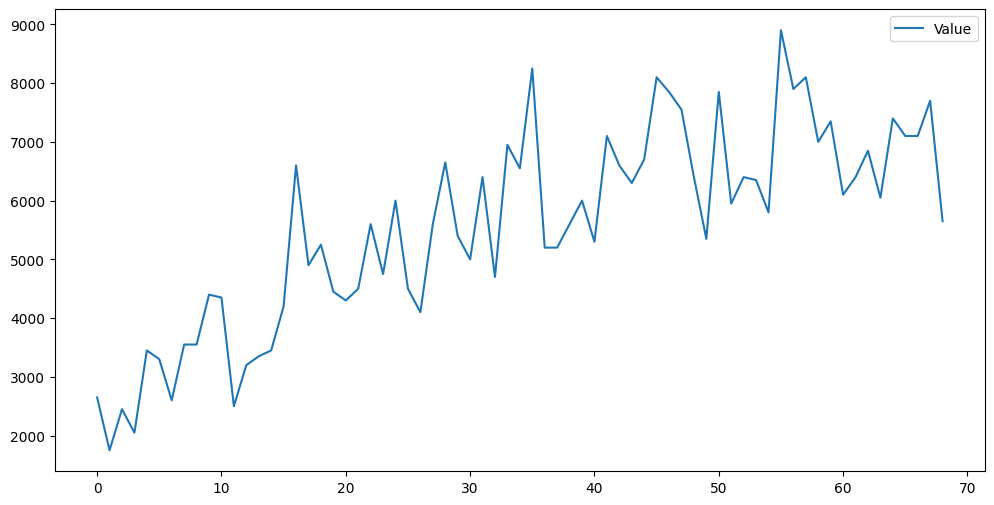

In [107]:
df_panel.plot(figsize=(12,6))

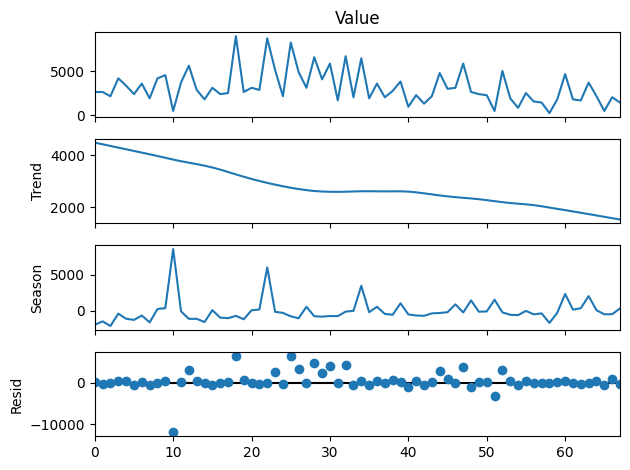

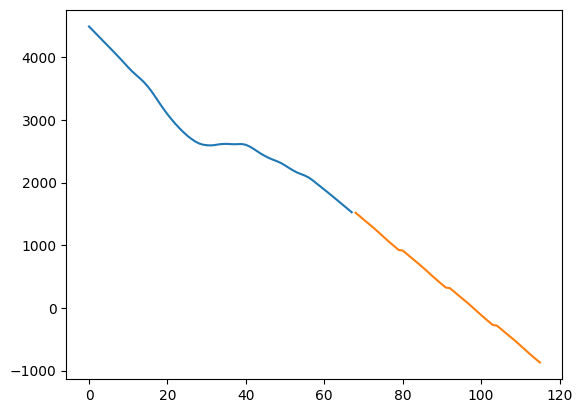

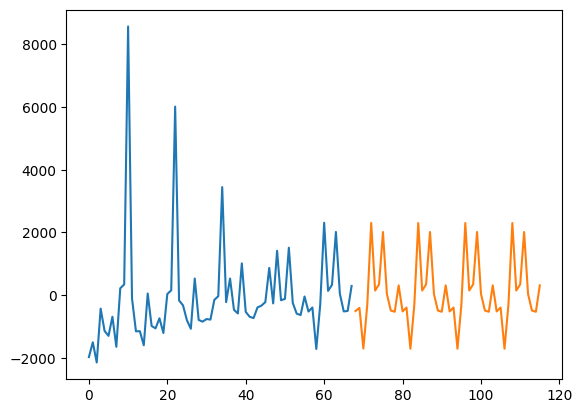

In [56]:
#from statsmodels.tsa.seasonal import seasonal_decompose # Depricated
from statsmodels.tsa.seasonal import STL


df_panel = pd.DataFrame(ts_cube_origin[0], columns=['Date', 'Value'])

stl = STL(df_panel['Value'][ ~pd.isna(df_panel['Value']) ], period=12, seasonal=13, robust=True)
results = stl.fit()
results.plot();
plt.show()
plt.close()

def predictComponents(graph, n=12, visual=0):
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.api import STLForecast

    # https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html
    # https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
    stlf = STLForecast(graph.trend, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=12)
    stlf_res = stlf.fit()
    trend = stlf_res.forecast(n)

    stlf = STLForecast(graph.seasonal, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=12)
    stlf_res = stlf.fit()
    seasonal = stlf_res.forecast(n)

    if visual:
        trend, seasonal = predictComponents(results, n=48)
        plt.plot(graph.trend)
        plt.plot(trend)
        plt.show()
        plt.close()

        plt.plot(graph.seasonal)
        plt.plot(seasonal)
        plt.show()
        plt.close()

    return trend, seasonal

predictComponents(results, n=48, visual=1);


# **Model Design**

In [57]:
# EVELIEN CONVERT TO TENSOR INPUT
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.date(year=year, month=month, day=day)


def df_to_windowed_df(dataframe, first_date, last_date, n=3):
    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Value'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_month = dataframe.loc[target_date:target_date+relativedelta(months=+1)]
        next_datetime_str = str(next_month.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.date(year=int(year), month=int(month), day=int(day))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


def prepTimeseries(ts_cube):
    # account for single timeseries input
    if len(ts_cube.shape) == 2:
        ts_cube = np.array([ts_cube])

    for i, _ in enumerate(ts_cube):
        # gather dates and values from ts_cube
        dates = ts_cube[i, :, 0]
        values = ts_cube[i, :, 1]

        # strip nan from values and remove relative dates
        dates = dates[~pd.isnull(values)]
        values = values[~pd.isnull(values)]

        # create date value pairs
        y = np.array(list(zip(dates, values)))


        df = pd.DataFrame(y,columns=['Date', 'Value'])
        df.index = df.pop('Date')
        print(f'Timeseries {i} | start date = {df.index[0]}')
        #display(df)

        # Start day second time around: '2021-03-25'
        windowSize = 12 # months
        if (i == 0):
            windowed_df = df_to_windowed_df(df,
                                        df.index[0]+relativedelta(months=+windowSize),
                                        df.index[-1],
                                        n=windowSize)
        else:
            new_windowed_df = df_to_windowed_df(df,
                                            df.index[0]+relativedelta(months=+windowSize),
                                            df.index[-1],
                                            n=windowSize)
            windowed_df = pd.concat([windowed_df, new_windowed_df], ignore_index=True)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    #display(windowed_df)
    #print(f'dates shape: {dates.shape}, train input X shape: {X.shape}, train target y shape: {y.shape}')
    return dates, X, y
dates, X, y = prepTimeseries(ts_cube)

Timeseries 0 | start date = 1990-01-01
Timeseries 1 | start date = 1990-01-01
Timeseries 2 | start date = 1990-01-01
Timeseries 3 | start date = 1990-01-01
Timeseries 4 | start date = 1990-01-01
Timeseries 5 | start date = 1990-01-01
Timeseries 6 | start date = 1990-01-01
Timeseries 7 | start date = 1990-01-01
Timeseries 8 | start date = 1990-01-01
Timeseries 9 | start date = 1990-01-01
Timeseries 10 | start date = 1990-01-01
Timeseries 11 | start date = 1990-01-01
Timeseries 12 | start date = 1990-01-01
Timeseries 13 | start date = 1990-01-01
Timeseries 14 | start date = 1990-01-01
Timeseries 15 | start date = 1990-01-01
Timeseries 16 | start date = 1990-01-01
Timeseries 17 | start date = 1990-01-01
Timeseries 18 | start date = 1990-01-01
Timeseries 19 | start date = 1990-01-01
Timeseries 20 | start date = 1990-01-01
Timeseries 21 | start date = 1990-01-01
Timeseries 22 | start date = 1990-01-01
Timeseries 23 | start date = 1990-01-01
Timeseries 24 | start date = 1990-01-01
Timeseries

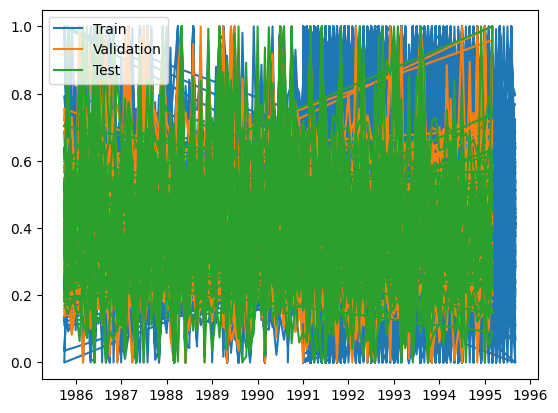

In [58]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [59]:
class LSTM_model():

    def make_model(self):
        input_shape = self.input_shape
        input_layer = layers.Input(input_shape)

        RNN_1     = layers.SimpleRNN(units=3, activation='tanh', return_sequences = True, name='RNN_1')(input_layer)
        dropout_1  = layers.Dropout(0.2)(RNN_1)
        RNN_2     = layers.SimpleRNN(units=3, activation='tanh', name='RNN_2')(dropout_1)
        prediction = layers.Dense(1, activation='sigmoid', name='predictionLayer')(RNN_2)
        model        = models.Model(inputs=input_layer, outputs=prediction)
        return model

    def show_graph(self):
        return model.summary()

    def __init__(self, input_shape, output):
        self.input_shape = input_shape
        self.output = output

In [21]:
np.shape(X)

(38229, 12, 1)

In [60]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers, models
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import schedules
from keras.metrics import *
import os

def saveCheckpoint(fold=False, name='model'):
    cwd = os.getcwd()
    if fold:
        filepath = os.path.join(cwd, "Checkpoints", f"{name}_fold_{fold}.ckpt")
    else:
        filepath = os.path.join(cwd, "Checkpoints", f"{name}.ckpt")
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    return checkpoint
earlystopping = EarlyStopping(monitor='val_loss', patience=15)
windowSize = 12

def createmodel(learning_rate=0.02, windowSize=12, architecture=LSTM_model(input_shape=(windowSize, 1), output=1)):
    model = architecture.make_model()
    model.compile(optimizer = SGD(learning_rate=learning_rate,
                                      momentum=0.9,
                                      nesterov=True),
                                      loss = "mean_squared_error",
                                      metrics=[MeanAbsoluteError(name="MAE"),
                                                MeanSquaredError(name="MSE (loss)"),
                                                 RootMeanSquaredError(name="RMSE")])
    return model

architecture = LSTM_model(input_shape=(windowSize, 1), output=1)
model = architecture.make_model()
model.compile(optimizer = SGD(learning_rate=0.02,
                                  momentum=0.9,
                                  nesterov=True),
                                  loss = "mean_squared_error",
                                  metrics=[MeanAbsoluteError(name="MAE"),
                                            MeanSquaredError(name="MSE (loss)"),
                                             RootMeanSquaredError(name="RMSE")])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[saveCheckpoint(name='basemodel'), earlystopping])


Epoch 1/15
955/956 [============================>.] - ETA: 0s - loss: 0.0272 - MAE: 0.1190 - MSE (loss): 0.0272 - RMSE: 0.1649
Epoch 1: val_loss improved from inf to 0.01961, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 23s 20ms/step - loss: 0.0272 - MAE: 0.1189 - MSE (loss): 0.0272 - RMSE: 0.1649 - val_loss: 0.0196 - val_MAE: 0.0994 - val_MSE (loss): 0.0196 - val_RMSE: 0.1400
Epoch 2/15
953/956 [============================>.] - ETA: 0s - loss: 0.0247 - MAE: 0.1103 - MSE (loss): 0.0247 - RMSE: 0.1573
Epoch 2: val_loss did not improve from 0.01961
956/956 [==============================] - 14s 15ms/step - loss: 0.0248 - MAE: 0.1104 - MSE (loss): 0.0248 - RMSE: 0.1575 - val_loss: 0.0197 - val_MAE: 0.0993 - val_MSE (loss): 0.0197 - val_RMSE: 0.1405
Epoch 3/15
954/956 [============================>.] - ETA: 0s - loss: 0.0245 - MAE: 0.1096 - MSE (loss): 0.0245 - RMSE: 0.1566
Epoch 3: val_loss improved from 0.01961 to 0.01893, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 20s 21ms/step - loss: 0.0245 - MAE: 0.1096 - MSE (loss): 0.0245 - RMSE: 0.1566 - val_loss: 0.0189 - val_MAE: 0.0977 - val_MSE (loss): 0.0189 - val_RMSE: 0.1376
Epoch 4/15
951/956 [============================>.] - ETA: 0s - loss: 0.0244 - MAE: 0.1088 - MSE (loss): 0.0244 - RMSE: 0.1562
Epoch 4: val_loss improved from 0.01893 to 0.01862, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 44s 46ms/step - loss: 0.0244 - MAE: 0.1087 - MSE (loss): 0.0244 - RMSE: 0.1561 - val_loss: 0.0186 - val_MAE: 0.0961 - val_MSE (loss): 0.0186 - val_RMSE: 0.1365
Epoch 5/15
951/956 [============================>.] - ETA: 0s - loss: 0.0243 - MAE: 0.1085 - MSE (loss): 0.0243 - RMSE: 0.1558
Epoch 5: val_loss improved from 0.01862 to 0.01852, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 15s 15ms/step - loss: 0.0243 - MAE: 0.1085 - MSE (loss): 0.0243 - RMSE: 0.1559 - val_loss: 0.0185 - val_MAE: 0.0955 - val_MSE (loss): 0.0185 - val_RMSE: 0.1361
Epoch 6/15
951/956 [============================>.] - ETA: 0s - loss: 0.0242 - MAE: 0.1082 - MSE (loss): 0.0242 - RMSE: 0.1557
Epoch 6: val_loss did not improve from 0.01852
956/956 [==============================] - 16s 17ms/step - loss: 0.0242 - MAE: 0.1082 - MSE (loss): 0.0242 - RMSE: 0.1557 - val_loss: 0.0187 - val_MAE: 0.0973 - val_MSE (loss): 0.0187 - val_RMSE: 0.1369
Epoch 7/15
955/956 [============================>.] - ETA: 0s - loss: 0.0241 - MAE: 0.1079 - MSE (loss): 0.0241 - RMSE: 0.1554
Epoch 7: val_loss improved from 0.01852 to 0.01843, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 17s 18ms/step - loss: 0.0241 - MAE: 0.1080 - MSE (loss): 0.0241 - RMSE: 0.1554 - val_loss: 0.0184 - val_MAE: 0.0952 - val_MSE (loss): 0.0184 - val_RMSE: 0.1358
Epoch 8/15
954/956 [============================>.] - ETA: 0s - loss: 0.0241 - MAE: 0.1078 - MSE (loss): 0.0241 - RMSE: 0.1552
Epoch 8: val_loss improved from 0.01843 to 0.01827, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 17s 18ms/step - loss: 0.0241 - MAE: 0.1079 - MSE (loss): 0.0241 - RMSE: 0.1553 - val_loss: 0.0183 - val_MAE: 0.0943 - val_MSE (loss): 0.0183 - val_RMSE: 0.1352
Epoch 9/15
955/956 [============================>.] - ETA: 0s - loss: 0.0241 - MAE: 0.1078 - MSE (loss): 0.0241 - RMSE: 0.1552
Epoch 9: val_loss improved from 0.01827 to 0.01819, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 18s 19ms/step - loss: 0.0241 - MAE: 0.1078 - MSE (loss): 0.0241 - RMSE: 0.1552 - val_loss: 0.0182 - val_MAE: 0.0937 - val_MSE (loss): 0.0182 - val_RMSE: 0.1349
Epoch 10/15
953/956 [============================>.] - ETA: 0s - loss: 0.0240 - MAE: 0.1077 - MSE (loss): 0.0240 - RMSE: 0.1550
Epoch 10: val_loss did not improve from 0.01819
956/956 [==============================] - 13s 14ms/step - loss: 0.0240 - MAE: 0.1076 - MSE (loss): 0.0240 - RMSE: 0.1550 - val_loss: 0.0184 - val_MAE: 0.0924 - val_MSE (loss): 0.0184 - val_RMSE: 0.1358
Epoch 11/15
955/956 [============================>.] - ETA: 0s - loss: 0.0240 - MAE: 0.1074 - MSE (loss): 0.0240 - RMSE: 0.1551
Epoch 11: val_loss improved from 0.01819 to 0.01793, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt
INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 20s 21ms/step - loss: 0.0240 - MAE: 0.1074 - MSE (loss): 0.0240 - RMSE: 0.1551 - val_loss: 0.0179 - val_MAE: 0.0912 - val_MSE (loss): 0.0179 - val_RMSE: 0.1339
Epoch 12/15
953/956 [============================>.] - ETA: 0s - loss: 0.0240 - MAE: 0.1073 - MSE (loss): 0.0240 - RMSE: 0.1548
Epoch 12: val_loss did not improve from 0.01793
956/956 [==============================] - 12s 13ms/step - loss: 0.0240 - MAE: 0.1073 - MSE (loss): 0.0240 - RMSE: 0.1549 - val_loss: 0.0186 - val_MAE: 0.0935 - val_MSE (loss): 0.0186 - val_RMSE: 0.1364
Epoch 13/15
954/956 [============================>.] - ETA: 0s - loss: 0.0239 - MAE: 0.1071 - MSE (loss): 0.0239 - RMSE: 0.1548
Epoch 13: val_loss did not improve from 0.01793
956/956 [==============================] - 12s 13ms/step - loss: 0.0239 - MAE: 0.1071 - MSE (loss): 0.0239 - RMSE: 0.1547 - val_loss: 0.0180 - val_MAE: 0.0921 - val_MSE (loss): 0.0180 - val_RMSE: 0.1343
Epoch 14/15
955/956 [==================

INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\basemodel.ckpt\assets


956/956 [==============================] - 20s 21ms/step - loss: 0.0239 - MAE: 0.1071 - MSE (loss): 0.0239 - RMSE: 0.1546 - val_loss: 0.0179 - val_MAE: 0.0909 - val_MSE (loss): 0.0179 - val_RMSE: 0.1336
Epoch 15/15
953/956 [============================>.] - ETA: 0s - loss: 0.0239 - MAE: 0.1069 - MSE (loss): 0.0239 - RMSE: 0.1545
Epoch 15: val_loss did not improve from 0.01786
956/956 [==============================] - 12s 13ms/step - loss: 0.0239 - MAE: 0.1069 - MSE (loss): 0.0239 - RMSE: 0.1545 - val_loss: 0.0186 - val_MAE: 0.0972 - val_MSE (loss): 0.0186 - val_RMSE: 0.1366


In [80]:
from collections import namedtuple
import itertools

Combination = namedtuple("Combination", "learning_rate")

learning_rate = np.array([0.01, 0.02, 0.05, 0.1, 0.2])

combinations = list(itertools.starmap(Combination, itertools.product(learning_rate)))
# combinations = list(itertools.starmap(Combination, itertools.product(learning_rate, neurons)))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import random
import keras

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs.
import tensorflow as tf
tf.get_logger().setLevel('WARN')

tscv = TimeSeriesSplit(n_splits=5)

def cross_validation(combination, x_train=X_train, y_train=y_train, tscv=tscv, name='model'):
    # k-Fold Cross Validation
    cv_results = []
    fold_counter = 1
    overall_best_model = None
    overall_best_val_loss = float('inf')
    architecture = LSTM_model(input_shape=(windowSize, 1), output=1)
    for train_index, test_index in tscv.split(x_train):
        print(f"Fold {fold_counter}/{tscv.get_n_splits()}:")
        x_train_cv, x_val_cv = x_train[train_index].tolist(), x_train[test_index].tolist()
        y_train_cv, y_val_cv = y_train[train_index].tolist(), y_train[test_index].tolist()

        model = createmodel(learning_rate=combination.learning_rate, architecture)
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)
        checkpoint = saveCheckpoint(fold_counter)
        history = model.fit(x_train_cv, y_train_cv, validation_data=(x_val_cv, y_val_cv), batch_size=20, epochs=10, callbacks=[checkpoint, early_stopping])

        mse = history.history['val_loss'][-1]
        cv_results.append(mse)

        cwd = os.getcwd()
        best_model = keras.models.load_model(os.path.join(cwd, "Checkpoints", f"{name}_fold_{fold_counter}.ckpt"))
        val_loss = best_model.evaluate(x_val_cv, y_val_cv)[0]
        if val_loss < overall_best_val_loss:
            print(f'Best fold : {fold_counter}, MSE is now: {val_loss}')
            overall_best_val_loss = val_loss
            overall_best_model = best_model

        #print(f"fold {fold_counter} Mean Squared Error:", mse)
        fold_counter += 1

    overall_best_model.save('basemodel_fold.ckpt')

    mean_mse = np.mean(cv_results)
    std_mse = np.std(cv_results)

    hyperparameters = {
          # 'balancing__target_n': combination.balancing__target_n,
          # 'augmentation__n_variants': combination.augmentation__n_variants,
          # 'extract__n_features': combination.extract__n_features,
          # 'vocabulary__k': combination.vocab__k,
          # 'svm__c': combination.svm__c,
          # 'svm__gamma': combination.svm__gamma,
          # 'svm__minority_weights': combination.svm__minority_weights,
          'learning_rate': combination.learning_rate
    }
    print(f"Current mean MSE: {mean_mse}, Current hyperparameters: {hyperparameters}")
    return mean_mse, std_mse, hyperparameters, overall_best_model

random_combinations = random.sample(combinations, 5)

import itertools

results = list(map(cross_validation, random_combinations, 
                   itertools.repeat(X, len(random_combinations)), 
                   itertools.repeat(y, len(random_combinations)), 
                   itertools.repeat(tscv, len(random_combinations)), 
                   itertools.repeat('model', len(random_combinations))))

optimal_mse = float('inf')
optimal_hyperparameters = {}
for result in results:
    mean_mse, std_mse, hyperparameters, model = result
    if mean_mse < optimal_mse:
        print(f'Best hyperparamers : {hyperparameters}, MSE is now: {mean_mse}')
        optimal_mse = mean_mse
        optimal_hyperparameters = hyperparameters
        optimal_best_model = model
        optimal_best_model.save('basemodel.ckpt')
print("Best Hyperparameters:", optimal_hyperparameters)
print("Best MSE Score:", optimal_mse)

Fold 1/5:
Epoch 1/10
311/312 [============================>.] - ETA: 0s - loss: 0.1585 - MAE: 0.3061 - MSE (loss): 0.1585 - RMSE: 0.3981
Epoch 1: val_loss improved from inf to 0.14225, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\model_fold_1.ckpt
312/312 [==============================] - 26s 51ms/step - loss: 0.1584 - MAE: 0.3061 - MSE (loss): 0.1584 - RMSE: 0.3981 - val_loss: 0.1423 - val_MAE: 0.2848 - val_MSE (loss): 0.1423 - val_RMSE: 0.3772
Epoch 2/10
308/312 [============================>.] - ETA: 0s - loss: 0.1505 - MAE: 0.2980 - MSE (loss): 0.1505 - RMSE: 0.3879
Epoch 2: val_loss improved from 0.14225 to 0.14208, saving model to C:\Users\Evelien\Documents\python3.9\Checkpoints\model_fold_1.ckpt
312/312 [==============================] - 12s 39ms/step - loss: 0.1503 - MAE: 0.2979 - MSE (loss): 0.1503 - RMSE: 0.3877 - val_loss: 0.1421 - val_MAE: 0.2845 - val_MSE (loss): 0.1421 - val_RMSE: 0.3769
Epoch 3/10
311/312 [============================>.] - ETA: 0s - 

In [83]:
optimal_mse = float('inf')
optimal_hyperparameters = {}
for result in results:
    mean_mse, std_mse, hyperparameters, model = result
    if mean_mse < optimal_mse:
        print(f'Best hyperparamers : {hyperparameters}, MSE is now: {mean_mse}')
        optimal_mse = mean_mse
        optimal_hyperparameters = hyperparameters
        optimal_best_model = model
        optimal_best_model.save('basemodel.ckpt')
print("Best Hyperparameters:", optimal_hyperparameters)
print("Best MSE Score:", optimal_mse)

Best hyperparamers : {'learning_rate': 0.1}, MSE is now: 0.14898806810379028
Best hyperparamers : {'learning_rate': 0.05}, MSE is now: 0.1480798453092575
Best hyperparamers : {'learning_rate': 0.02}, MSE is now: 0.14799471497535704
Best hyperparamers : {'learning_rate': 0.01}, MSE is now: 0.14719929099082946
Best Hyperparameters: {'learning_rate': 0.01}
Best MSE Score: 0.14719929099082946


In [61]:
# Loads the weights
windowSize = 12
architecture = LSTM_model(input_shape=(windowSize, 1), output=1)
model = architecture.make_model()
model.compile(optimizer=Adam(learning_rate=0.02),
                              loss = "mean_squared_error",
                              metrics=[MeanAbsoluteError(name="MAE"),
                                        MeanSquaredError(name="MSE (loss)"),
                                         RootMeanSquaredError(name="RMSE")])
model.summary()

model.load_weights('basemodel.ckpt')

ts_panel = 473
ts_panel = ts_cube[ts_panel]
dates_temp, X_temp, y_temp = prepTimeseries(ts_panel)
q_80 = int(len(dates_temp) * .8)
q_90 = int(len(dates_temp) * .9)

dates_train2, X_train2, y_train2 = dates_temp[:q_80], X_temp[:q_80], y_temp[:q_80]

dates_val2, X_val2, y_val2 = dates_temp[q_80:q_90], X_temp[q_80:q_90], y_temp[q_80:q_90]
dates_test2, X_test2, y_test2 = dates_temp[q_90:], X_temp[q_90:], y_temp[q_90:]

model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=10, callbacks=[saveCheckpoint(name='finetuned'), earlystopping])

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 12, 1)]           0         
                                                                 
 RNN_1 (SimpleRNN)           (None, 12, 3)             15        
                                                                 
 dropout_17 (Dropout)        (None, 12, 3)             0         
                                                                 
 RNN_2 (SimpleRNN)           (None, 3)                 21        
                                                                 
 predictionLayer (Dense)     (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Timeseries 0 | start d

INFO:tensorflow:Assets written to: C:\Users\Evelien\Documents\python3.9\Checkpoints\finetuned.ckpt\assets


3/3 [==============================] - 12s 3s/step - loss: 0.0189 - MAE: 0.0893 - MSE (loss): 0.0189 - RMSE: 0.1377 - val_loss: 2.0493e-04 - val_MAE: 0.0123 - val_MSE (loss): 2.0493e-04 - val_RMSE: 0.0143
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - MAE: 0.0648 - MSE (loss): 0.0074 - RMSE: 0.0862
Epoch 2: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 63ms/step - loss: 0.0171 - MAE: 0.0756 - MSE (loss): 0.0171 - RMSE: 0.1309 - val_loss: 5.9367e-04 - val_MAE: 0.0198 - val_MSE (loss): 5.9367e-04 - val_RMSE: 0.0244
Epoch 3/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - MAE: 0.0601 - MSE (loss): 0.0080 - RMSE: 0.0895
Epoch 3: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 63ms/step - loss: 0.0163 - MAE: 0.0791 - MSE (loss): 0.0163 - RMSE: 0.1278 - val_loss: 0.0021 - val_MAE: 0.0441 - val_MSE (loss): 0.0021 - val_RMSE: 0.0463
Epoch 4/10
1/3 [=========>....................] - E

In [32]:
y_train2

array([ 0.631043  ,  0.336733  ,  0.27483007,  0.2463731 ,  0.28960982,
        0.320723  ,  1.        ,  0.36993653,  0.2959166 ,  0.26557523,
        0.27528623,  0.5638522 ,  0.26155502,  0.9844366 ,  0.6544592 ,
        0.28924572,  0.8145986 ,  0.5489425 ,  0.73642707,  0.28239083,
        0.76077974,  0.23887345,  0.3419271 ,  0.24518615,  0.3464393 ,
        0.2855957 ,  0.37627196,  0.31958985,  0.1763626 ,  0.33982056,
        0.24409577,  0.3029679 ,  0.5880651 ,  0.38393778,  0.2816981 ,
        0.7076388 ,  0.17552602,  0.32419506,  0.31055954, -0.05834301,
        0.63304615,  0.33462614,  0.22505265,  0.34573972,  0.29705182,
        0.274569  ,  0.29367685,  0.31431004,  0.3490367 ,  0.27789968,
        0.24944513,  0.29321817,  0.34317267,  0.22820029,  0.40185323,
        0.25555843], dtype=float32)

In [76]:
# Loads the weights
def predictPanel(ts_panel):
    model = architecture.make_model()
    model.compile(optimizer=Adam(learning_rate=0.0001),
                                  loss = "mean_squared_error",
                                  metrics=[MeanAbsoluteError(name="MAE"),
                                            MeanSquaredError(name="MSE (loss)"),
                                             RootMeanSquaredError(name="RMSE")])
    model.summary()
    cwd = os.getcwd()
    filepath = os.path.join(cwd, "Checkpoints", "finetuned.ckpt")
    model.load_weights(filepath)
    
    dates_temp, X_temp, y_temp = prepTimeseries(ts_panel)
    
    train_predictions = model.predict(X_temp).flatten()  # np.expand_dims(X_temp[0], axis=0) for 1 prediction
    
    plt.plot(dates_temp, train_predictions)
    plt.plot(dates_temp, y_temp)
    plt.legend(['Training Predictions', 'Training Observations'])
    return dates_temp, train_predictions

In [37]:
train_predictions.shape

(56,)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 12, 1)]           0         
                                                                 
 RNN_1 (SimpleRNN)           (None, 12, 3)             15        
                                                                 
 dropout_31 (Dropout)        (None, 12, 3)             0         
                                                                 
 RNN_2 (SimpleRNN)           (None, 3)                 21        
                                                                 
 predictionLayer (Dense)     (None, 1)                 4         
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Timeseries 0 | start d

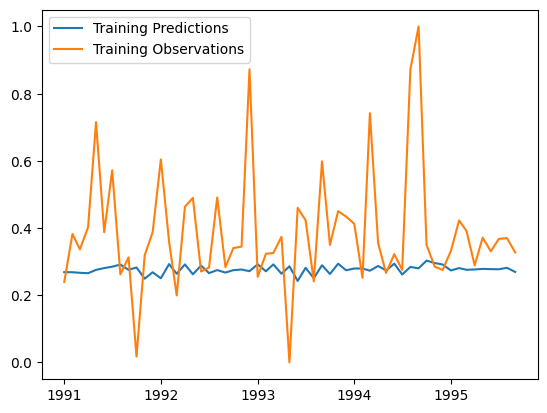

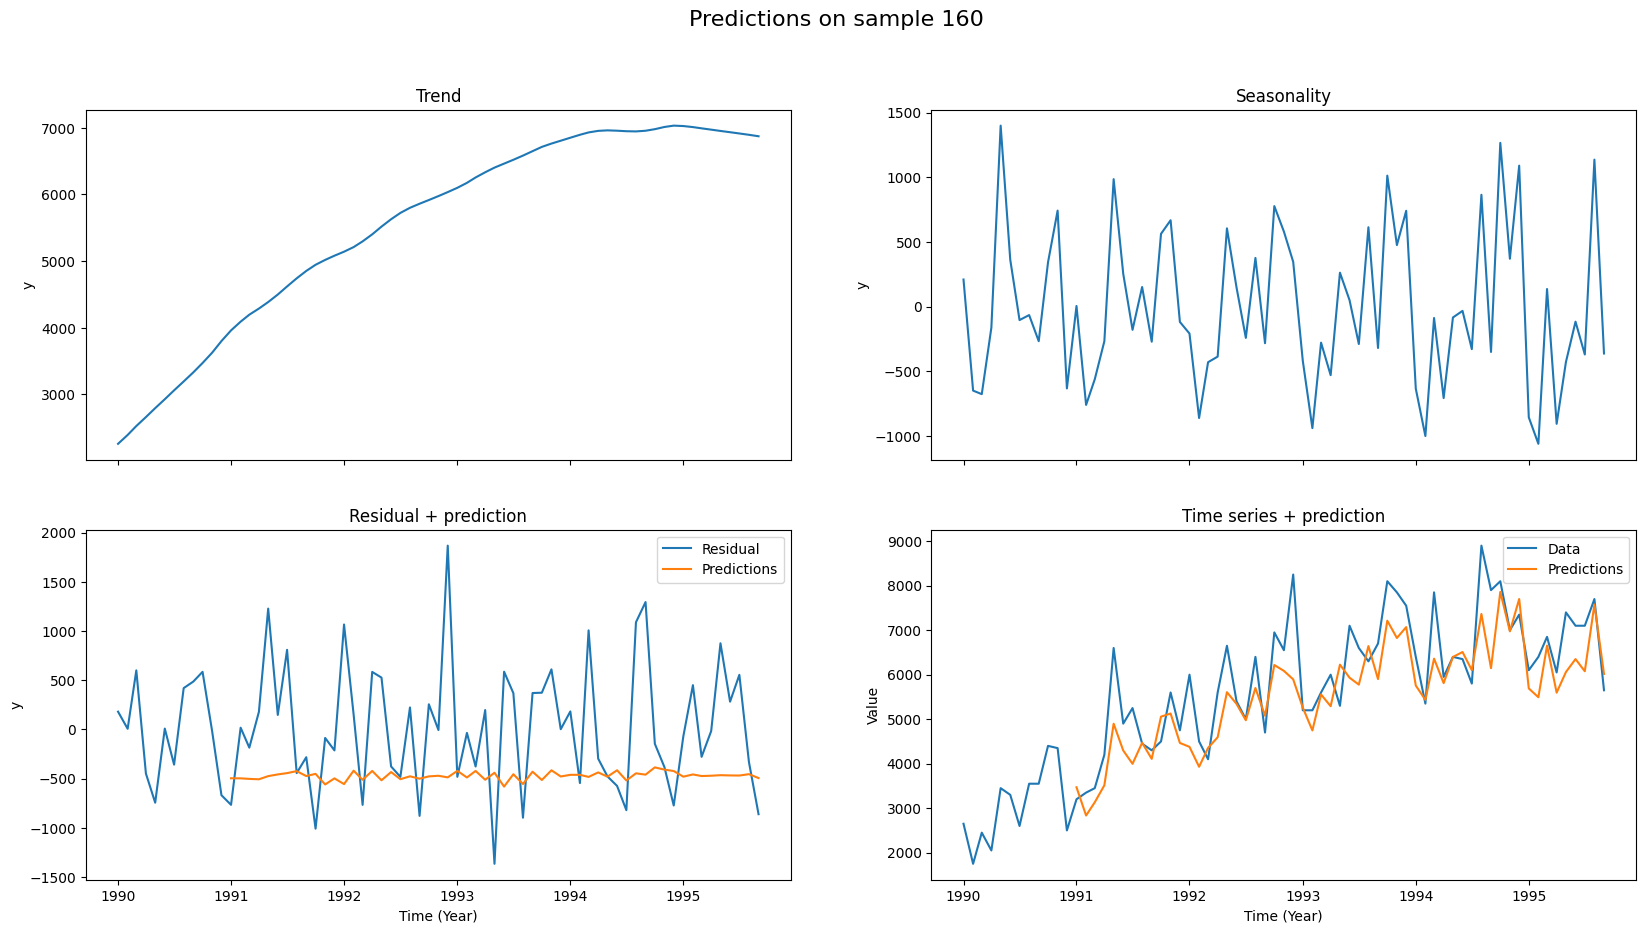

In [89]:
# TECHNIQUE FOR RESTORING PREDICTED DATA TO FIT THE ORIGINAL TIME SERIES
from statsmodels.tsa.seasonal import STL
from random import randrange

def plotPanelPredictions(ts_panel, dates_pred, predictions, sample):
    # load in data
    original = pd.DataFrame(ts_panel,columns=['Date', 'Value'])
    original = original[original['Value'].notna()] # original values of the timeseries]
    
    # set the date range
    daterange = original['Date']
    original = original['Value'].astype(np.float64)
    
    # gather seasonality
    stl = STL(original[ ~pd.isna(original) ], period=12, seasonal=13)
    results = stl.fit()
    
    # load rest of the data
    residual = results.resid  # loading in the residual
    seasonal = results.seasonal # loading in the seasonal
    trend = results.trend     # loading in the trend
    
    # figure with 4 plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all')
    fig.set_size_inches(w=20, h=10)
    fig.suptitle(f'Predictions on sample {sample}', fontsize=16)
    
    # plot 1 (top-left) has the df.index(dates) and the value after detrending, deseasoning and normalizing
    ax1.plot(daterange, trend)
    ax1.set_ylabel('y')
    ax1.set_title('Trend')
    
    # plot 2 (top-right) has the original residual (similar to plot 1, but without normalization between -1 and 1)
    ax2.plot(daterange, seasonal)
    ax2.set_ylabel('y')
    ax2.set_title('Seasonality')
    
    # initialize the scaler on the original timeseries to get the ratio for inversion
    scaler = MinMaxScaler((0,1))
    scaler.fit(np.array(residual).reshape(-1, 1))
    
    # revert the scaler transformation (from -1 to 1 back to original values)
    inverse_transform = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    inverse_transform = flatten(inverse_transform)
    
    # plot 3 (bottom-left) of the original data
    ax3.plot(daterange, residual)
    ax3.plot(dates_pred, inverse_transform)
    ax3.set_xlabel('Time (Year)')
    ax3.set_ylabel('y')
    ax3.set_title('Residual + prediction')
    ax3.legend(['Residual', 'Predictions'])
    
    # summing the previously modified residual with the seasonality and the trend
    approx = inverse_transform+(seasonal[12:]+trend[12:])
    
    # plot 4 (bottom-right) of the restored data (should be again equal to the original data if succesful)
    ax4.plot(daterange, original)
    ax4.plot(dates_pred, approx)
    ax4.set_xlabel('Time (Year)')
    ax4.set_ylabel('Value')
    ax4.set_title('Time series + prediction')
    ax4.legend(['Data', 'Predictions'])
    plt.savefig("current_pred.png", dpi=400)


sample = randrange(len(ts_cube))
ts_panel_origin = ts_cube_origin[sample]
ts_panel_normal = ts_cube[sample]
dates_pred, predictions = predictPanel(ts_panel_normal)
predictions = plotPanelPredictions(ts_panel_origin, dates_pred, predictions, sample)

Timeseries 0 | start date = 1984-10-01
1/1 [==============================] - 0s 72ms/step


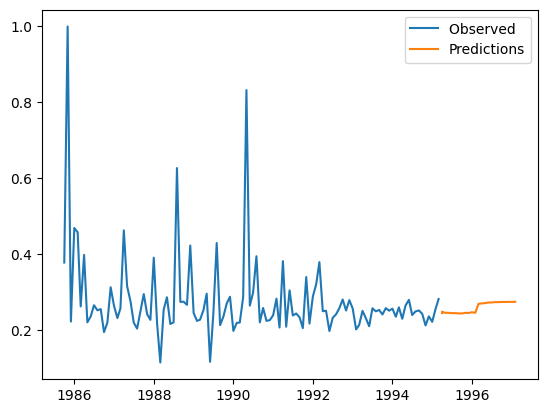

In [65]:
def predictResidual(ts_panel, timesteps=24):
    dates_temp, X_temp, y_temp = prepTimeseries(ts_panel)

    dates_pred = np.array(dates_temp[-1]+relativedelta(months=+1))
    predictions = np.array(model.predict(np.expand_dims(np.expand_dims(y_temp[-12:], axis=0), axis=2)).flatten())

    for i in range(timesteps-1):
        values = np.concatenate((y_temp[-12+i+1:], predictions), axis=None)
        predictions = np.append(predictions, model.predict(np.expand_dims(np.expand_dims(values, axis=0), axis=2)).flatten())
        dates_pred = np.append(dates_pred, dates_temp[-1]+relativedelta(months=+1+i))

    plt.plot(dates_temp, y_temp)
    plt.plot(dates_pred, predictions)
    plt.legend(['Observed ', 'Predictions'])
    return dates_pred, predictions
dates_pred, predictions = predictResidual(ts_cube[473])

Timeseries 0 | start date = 1984-10-01
1/1 [==============================] - 0s 79ms/step
0      2710.0
1      2500.0
2      2900.0
3      2570.0
4      3675.0
        ...  
121    2675.0
122    2550.0
123    2650.0
124    2800.0
125    3015.0
Name: Value, Length: 126, dtype: float64


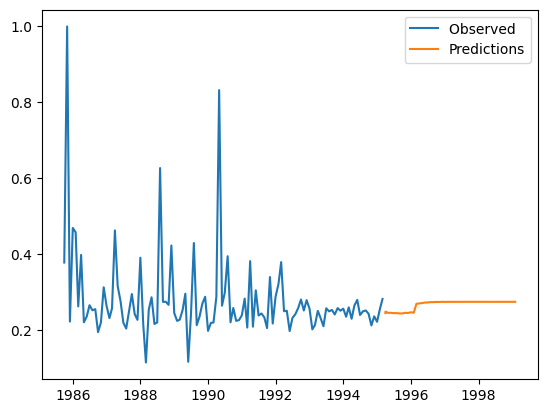

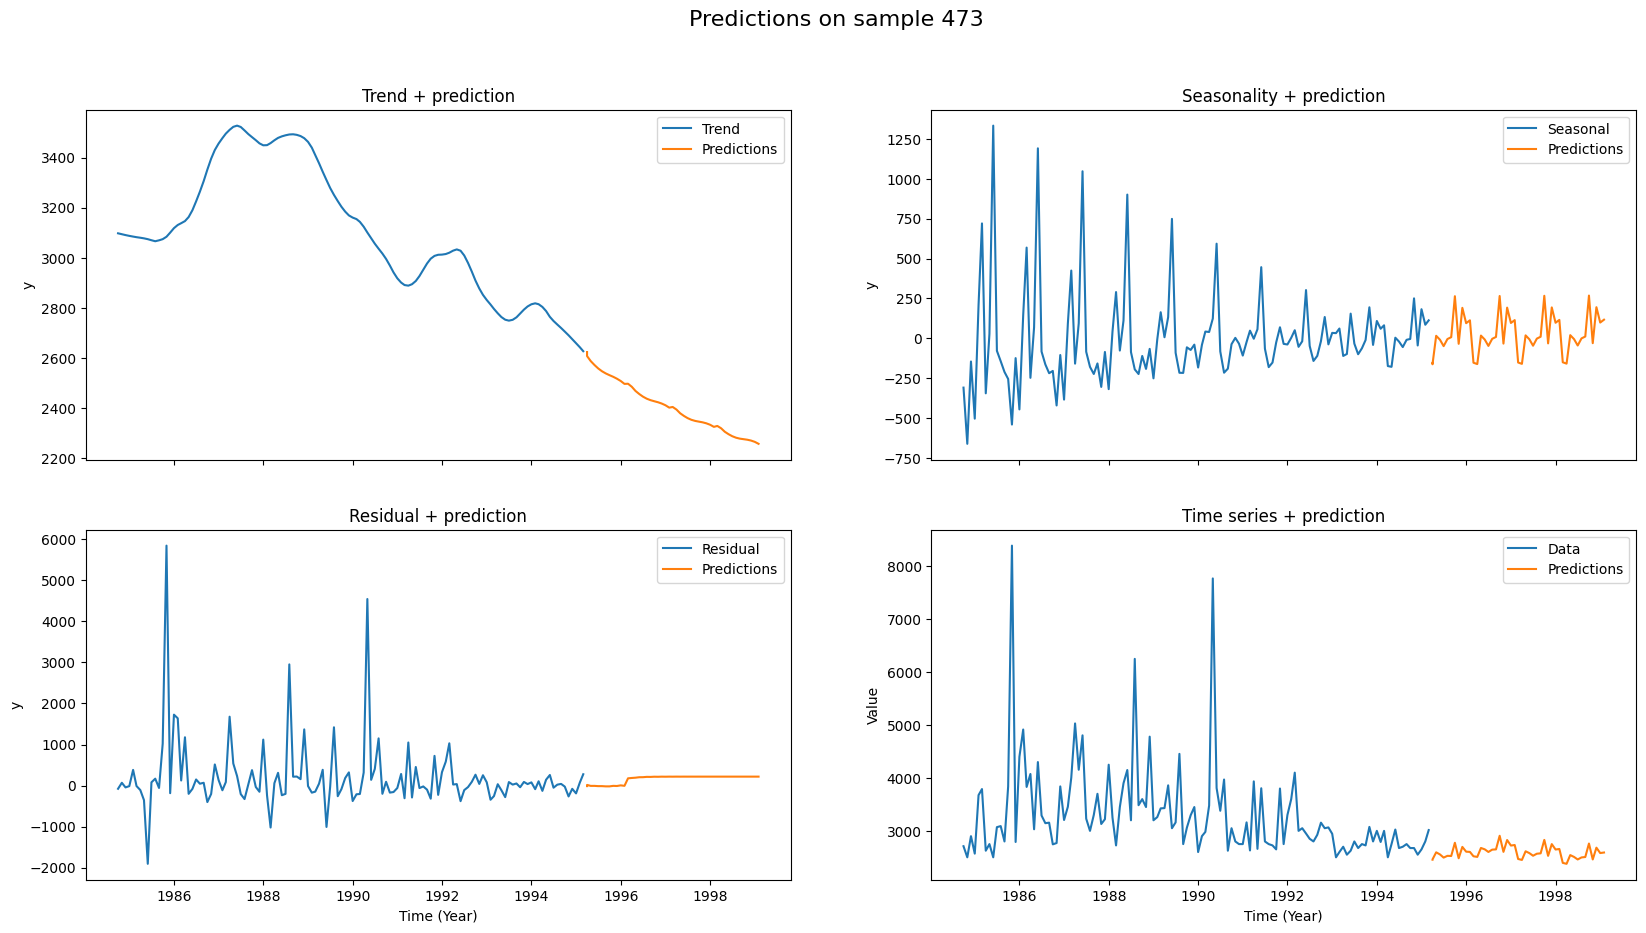

In [69]:
def plotFuturePredictions(ts_panel, dates_pred, predictions, sample):


    # load in data
    original = pd.DataFrame(ts_panel,columns=['Date', 'Value'])
    original = original[original['Value'].notna()] # original values of the timeseries]

    # set the date range
    dates_orig = original['Date']
    original = original['Value'].astype(np.float64)

    # gather seasonality
    stl = STL(original[ ~pd.isna(original) ], period=12, seasonal=13, robust=True)
    results = stl.fit()

    # load rest of the data
    residual = results.resid  # loading in the residual
    seasonal = results.seasonal # loading in the seasonal
    trend = results.trend     # loading in the trend

    # predict seasonality and trend
    # https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html
    # https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
    n = len(predictions)
    trend_pred, seasonal_pred = predictComponents(results, n=n, visual=0)

    # figure with 4 plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all')
    fig.set_size_inches(w=20, h=10)
    fig.suptitle(f'Predictions on sample {sample}', fontsize=16)

    # plot 1 (top-left) trend + prediction
    ax1.plot(dates_orig, trend)
    ax1.plot(dates_pred, trend_pred)
    #ax1.set_xlabel('Time (Year)')
    ax1.set_ylabel('y')
    ax1.set_title('Trend + prediction')
    ax1.legend(['Trend', 'Predictions'])

    # plot 2 (top-right) seasonal + prediction
    ax2.plot(dates_orig, seasonal)
    ax2.plot(dates_pred, seasonal_pred)
    #ax2.set_xlabel('Time (Year)')
    ax2.set_ylabel('y')
    ax2.set_title('Seasonality + prediction')
    ax2.legend(['Seasonal', 'Predictions'])

    # initialize the scaler on the original timeseries to get the ratio for inversion
    scaler = MinMaxScaler((0,1))
    scaler.fit(np.array(residual).reshape(-1, 1))

    # revert the scaler transformation (from -1 to 1 back to original values)
    inverse_transform = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    inverse_transform = flatten(inverse_transform)

    # plot 3 (bottom-left) residual + prediction
    ax3.plot(dates_orig, residual)
    ax3.plot(dates_pred, inverse_transform)
    ax3.set_xlabel('Time (Year)')
    ax3.set_ylabel('y')
    ax3.set_title('Residual + prediction')
    ax3.legend(['Residual', 'Predictions'])

    # summing the previously modified residual with the seasonality and the trend
    estimated = inverse_transform+seasonal_pred+trend_pred

    # plot 4 (bottom-right) of the restored data (should be again equal to the original data if succesful)
    print(original)
    ax4.plot(dates_orig, original)
    ax4.plot(dates_pred, estimated)
    ax4.set_xlabel('Time (Year)')
    ax4.set_ylabel('Value')
    ax4.set_title('Time series + prediction')
    ax4.legend(['Data', 'Predictions'])
    plt.savefig("future_pred.png", dpi=400)
    return estimated

sample = 473
ts_panel_origin = ts_cube_origin[sample]
ts_panel_normal = ts_cube[sample]
dates_pred, predictions = predictResidual(ts_panel_normal, timesteps=48)
predictions = plotFuturePredictions(ts_panel_origin, dates_pred, predictions, sample)

In [ ]:
len(predictions)

48

In [ ]:
len(y_test[:48])

48

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(predictions, y_test[:48]))
print(rmse)

3834.7477731081713


# **RNN**

In [ ]:
!pip install yfinance==0.2.36

In [ ]:

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math

In [ ]:
df = pd.read_excel('M3C.xls', sheet_name='M3Month')

# filter usable data
df = df[(df['Starting Month'] >= 1) & (df['Starting Month'] <= 12)]


# filter category (options: MICRO, ..)
df = df[(df['Category'].str.match('MICRO'))]
df = df.reset_index()  # make sure indexes pair with number of rows


import datetime
from dateutil.relativedelta import *
from sklearn.preprocessing import MinMaxScaler

def flatten(xss):
    return [x for xs in xss for x in xs]

def detrend_deseason_normalise(ts_cube):
    from statsmodels.tsa.seasonal import seasonal_decompose
    #print(ts_cube.shape)
    for slide in ts_cube:
        fullseries = slide[:,1] # the unchanged timeseries
        #print(f"fullseries:\n{fullseries}\n{fullseries.shape}")

        # the residual after deseasoning and detrending:
        tseries = seasonal_decompose(fullseries[ ~pd.isna(fullseries) ], period=12).resid
        #print(f"tseries\n{tseries}\n{tseries.shape}")
        tseries = np.array(tseries)

        # normalize residual (-1..1):
        scaler = MinMaxScaler((-1,1))
        scaler.fit(tseries.reshape(-1, 1))
        scaled_tseries = scaler.transform(tseries.reshape(-1, 1))
        scaled_tseries = np.array(flatten(scaled_tseries))
        #print(f"scaled_tseries\n{scaled_tseries}\n{scaled_tseries.shape}")

        # insert back in the full timeseries > slide > cube
        fullseries[ ~pd.isna(fullseries) ] = scaled_tseries
        #print(f"fullseries:\n{fullseries}\n{fullseries.shape}")
        slide[:,1] = fullseries # inserting it back in the slide
    return ts_cube


# key - index pairs of the column titles
columns = df.columns.to_list()
colIdx = dict(zip(columns, range(1,len(columns)+1)))

ts_cube = []
# fast row iteration
# each row is a new time series
for row in df.itertuples():
    #val[row.Index] =
    date = datetime.date(row[colIdx['Starting Year']], row[colIdx['Starting Month']], 1)
    #print(row[colIdx['Starting Month']+1:])
    ts_panel = []
    financial_data = []
    for value in row[colIdx['Starting Month']+1:]:
      pair = [date, value] # [date.strftime('%Y-%m-%d'), value]
      ts_panel.append(pair)
      date += relativedelta(months=+1)
    ts_cube.append(ts_panel)
ts_cube = np.array(ts_cube)
df_panel = pd.DataFrame(ts_cube[0], columns=['D', 'V'])
# print(df_panel)
# print(ts_cube.shape)
# print(ts_cube[0])
ts_cube = detrend_deseason_normalise(ts_cube)
ts_cube = np.array(ts_cube)
# df_depanel = pd.DataFrame(ts_cube[0], columns=['D', 'V'])

# print(ts_cube[0][0])


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

def clean_nan(data):
    new_data = []
    for i in range(len(data)):
        dummy = []
        for j in range(len(data[i])):
            if np.isnan(data[i][j][1]) == False:
                dummy.append(data[i][j][1])
        new_data.append(dummy)
    return new_data
clean_ts = clean_nan(ts_cube)

def make_input(data):
    dataset = []
    for i in range(len(data)):
        for j in range(len(data[i]) - 20):
            scaler.fit(np.reshape(clean_ts[i], (-1,1)))
            scaled = (np.reshape(scaler.transform(np.reshape(clean_ts[i], (-1,1))), (len(clean_ts[i]), )))
            element = scaled[j:20 + j]
            dataset.append( (element, scaled[j + 20 ]) )
    return dataset


In [ ]:
input_ts = make_input(clean_ts)

plt.plot(input_ts[0][0])

# len(clean_ts)
# np.reshape(scaler.fit_transform(np.reshape(clean_ts[0], (-1,1))), (len(clean_ts[0]), ))[5]
# np.array(clean_ts[0]).shape

In [ ]:
# Create the training (80%) and testing (20%) datasets.
# Each of them contains the X input (a series of 20 values) and
# the input Y, a single value which is the next value in time

df_final_data = pd.DataFrame(input_ts)
train_data = df_final_data.iloc[:round(len(df_final_data) * 0.8)]
test_data = df_final_data.iloc[round(len(df_final_data) * 0.8):]
X_train = list(np.array(train_data.iloc[:,0]))
y_train = list(np.array(train_data.iloc[:,1]))
X_train = np.reshape(np.array(X_train), (len(X_train), len(X_train[0]), 1))
y_train = np.reshape(np.array(y_train), (len(y_train), 1))
X_test = list(np.array(test_data.iloc[:,0]))
y_test = list(np.array(test_data.iloc[:,1]))
X_test = np.reshape(np.array(X_test), (len(X_test), len(X_test[0]), 1))
y_test = np.reshape(np.array(y_test), (len(y_test), 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test[0].shape[0],1))
# np.reshape(X_test[0], (-1,1))
# for i in range(len(X_test)):
#     X_test[i] = (np.reshape(X_test[i], (20,1)))
# type((list(X_test)))
X_train.shape

In [ ]:
y_train = np.reshape(y_train, (22999 ,))
y_train.shape

In [ ]:
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 3,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# regressor.add(SimpleRNN(units = 5,
#                         activation = "tanh",
#                         return_sequences = True))

# regressor.add(SimpleRNN(units = 50,
#                         activation = "tanh",
#                         return_sequences = True))

regressor.add( SimpleRNN(units = 3))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  decay=1e-6,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

In [ ]:
y_RNN = regressor.predict(X_test)

In [ ]:
y_RNN[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_RNN[0:100])
plt.plot(y_test[0:100])

In [ ]:
y_RNN_O = scaler.inverse_transform(y_RNN)

In [ ]:
n = 0
w = 20
d = 20
plt.plot(X_test[n], label = "Training")
# plt.plot(clean_ts[-114][0:d])
plt.plot(np.arange(len(X_test[n]), len(X_test[n]) + w, 1), y_test[n:n+w], label = "Real Values")
# plt.plot(np.arange(d, d + w, 1), clean_ts[-114][d:d+w])
plt.plot(np.arange(d, d + w, 1), y_RNN[0:20])
# plt.plot(np.arange(len(X_test[n]), len(X_test[n]) + w, 1), y_RNN[500], label = "Prediction")
plt.legend()
plt.show()

In [ ]:
# Reshaping 1D to 2D array
train_data = np.reshape(train_data, (-1,1))
test_data = np.reshape(test_data, (-1,1))

train_data.shape
test_data

In [ ]:
train_data.iloc[1]

In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.fit_transform(test_data)

print(scaled_train[:5])

In [ ]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

In [ ]:
len(scaled_test)

In [ ]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    # print("fer")
    X_test.append(scaled_test[i-50:i, 0])
    # print(scaled_test[i-20:i, 0])
    y_test.append(scaled_test[i, 0])

In [ ]:

# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

In [ ]:
X_test

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [ ]:
y_RNN = regressor.predict(X_test)


In [ ]:

# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)

In [ ]:
n = 0
w = 20
d = 20
plt.plot(X_test[n], label = "Training")
# plt.plot(clean_ts[-114][0:d])
plt.plot(np.arange(len(X_test[n]), len(X_test[n]) + w, 1), y_test[n:n+w], label = "Real Values")
# plt.plot(np.arange(d, d + w, 1), clean_ts[-114][d:d+w])
# plt.plot(np.arange(d, d + w, 1), y_RNN_O[-94:-74])
plt.plot(np.arange(len(X_test[n]), len(X_test[n]) + w, 1), y_RNN[n:n+w], label = "Prediction")
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[50:], train_data[50:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

In [ ]:
df = pd.read_excel('M3C.xls', sheet_name='M3Month')

# filter usable data
df = df[(df['Starting Month'] >= 1) & (df['Starting Month'] <= 12)]


# filter category (options: MICRO, ..)
df = df[(df['Category'].str.match('MICRO'))]
df = df.reset_index()  # make sure indexes pair with number of rows

In [ ]:
df = pd.read_excel('M3C.xls', sheet_name='M3Month')

# filter usable data
df = df[(df['Starting Month'] >= 1) & (df['Starting Month'] <= 12)]


# filter category (options: MICRO, ..)
df = df[(df['Category'].str.match('MICRO'))]
df = df.reset_index()  # make sure indexes pair with number of rows


import datetime
from dateutil.relativedelta import *
from sklearn.preprocessing import MinMaxScaler

def flatten(xss):
    return [x for xs in xss for x in xs]

def detrend_deseason_normalise(ts_cube):
    from statsmodels.tsa.seasonal import seasonal_decompose
    #print(ts_cube.shape)
    for slide in ts_cube:
        fullseries = slide[:,1] # the unchanged timeseries
        #print(f"fullseries:\n{fullseries}\n{fullseries.shape}")

        # the residual after deseasoning and detrending:
        tseries = seasonal_decompose(fullseries[ ~pd.isna(fullseries) ], period=12).resid
        #print(f"tseries\n{tseries}\n{tseries.shape}")
        tseries = np.array(tseries)

        # normalize residual (-1..1):
        scaler = MinMaxScaler((-1,1))
        scaler.fit(tseries.reshape(-1, 1))
        scaled_tseries = scaler.transform(tseries.reshape(-1, 1))
        scaled_tseries = np.array(flatten(scaled_tseries))
        #print(f"scaled_tseries\n{scaled_tseries}\n{scaled_tseries.shape}")

        # insert back in the full timeseries > slide > cube
        fullseries[ ~pd.isna(fullseries) ] = scaled_tseries
        #print(f"fullseries:\n{fullseries}\n{fullseries.shape}")
        slide[:,1] = fullseries # inserting it back in the slide
    return ts_cube


# key - index pairs of the column titles
columns = df.columns.to_list()
colIdx = dict(zip(columns, range(1,len(columns)+1)))

ts_cube = []
# fast row iteration
# each row is a new time series
for row in df.itertuples():
    #val[row.Index] =
    date = datetime.date(row[colIdx['Starting Year']], row[colIdx['Starting Month']], 1)
    #print(row[colIdx['Starting Month']+1:])
    ts_panel = []
    financial_data = []
    for value in row[colIdx['Starting Month']+1:]:
      pair = [date, value] # [date.strftime('%Y-%m-%d'), value]
      ts_panel.append(pair)
      date += relativedelta(months=+1)
    ts_cube.append(ts_panel)
ts_cube = np.array(ts_cube)
df_panel = pd.DataFrame(ts_cube[0], columns=['D', 'V'])
# print(df_panel)
# print(ts_cube.shape)
# print(ts_cube[0])
ts_cube = detrend_deseason_normalise(ts_cube)
ts_cube = np.array(ts_cube)
# df_depanel = pd.DataFrame(ts_cube[0], columns=['D', 'V'])

# print(ts_cube[0][0])


In [ ]:
plt.plot(ts_cube[0][:,1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b03471b-5a54-4bd6-9cf1-88de36f86a31' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>